# Solving the OLG model with an iterative, binary search algorithm

This project explores how the optimal savings rate in a 2 period OLG setting can be computed via an iterative binary search algorithm. We also extend the model by relaxing the assumption of log utility, allowing for a more general solution based on the CRRA utility function. We will also investigate how the optimal model solution changes with different parameter values.

Imports and set magics:

In [2]:

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject as mp 

First step is to set up our OLG model. This means defining consumption functions for young and old agents, defining a cummulative, log utility function to be maximized and defining parameter values for the wage, interest rate and utility discount rate.
For each agent the utility function to be maximized is given by: $$Utility = log(c_y)+B*log(c_o)$$ where c_y is consumption while young and c_o is consumption while old. As the agents in this economy live for 2 periods, they reflect on both their current and future consumption when deciding how to behave with regards to saving/consuming. The B parameter is a discount factor, reflecting the fact that agents prefer consumption today over consumption tommorow all things equal. 

Consumption while young, c_y, is given by: $$c_y = w-s$$ where s is the savings chosen by the agent and w is the wage earned.
Consumption while old, c_o, is given by: $$c_o = (1+r)*s$$ where r is the interest rate and s is the savings of the agent.

The next step is to create an algorithm that can solve the model by finding the optimal savings level for an agent (indirectly, we are also finding the optimal consumption level this way). We have chosen a binary search, iterative algorithm that works in the following way:

The algorithm starts by defining the lower and upper bounds of the savings (s_lower and s_upper). In this OLG model, the bounds are set between a very small number close to zero, to ensure positive consumption, and the wage, to ensure savings do not exceed income.

Each iteration of the algorithm involves calculating the midpoint, s_mid, of the current s_lower and s_upper. The utility is then evaluated at three points, s_lower, s_mid and s_upper, based on the given utility function and the given value of savings.

Next, the algorithm computes the change in utiltiy between s_lower and s_mid and s_mid and s_upper. If the change in utility between s_lower and s_mid is greater than s_mid to s_upper the algorithm adjusts s_upper to s_mid. Otherwise, it adjusts s_lower to s_mid. This iterative search continues until the difference between s_lower and s_upper falls below a predefined tolerance level given by 'tolerance'. When the algorithm breaks, the optimal savings level is then found as the average of s_lower and s_upper (these two numbers will be almost identical at this point).

Since we compute a change in utiltiy and not a formal derivative, we could use any utiltiy function in our model, including ones that might not be differentiable. For this first round of solving the model we will use the log utility function described earlier.
$$utility = log(c_y)+B*log(c_o)$$

Beta=0.9: Optimal Savings=0.4737, Young Consumption=0.5263, Old Consumption=0.4926
Beta=0.96: Optimal Savings=0.4898, Young Consumption=0.5102, Old Consumption=0.5094
Beta=1.02: Optimal Savings=0.5050, Young Consumption=0.4950, Old Consumption=0.5251
Interest Rate=0.02: Optimal Savings=0.4898, Young Consumption=0.5102, Old Consumption=0.4996
Interest Rate=0.04: Optimal Savings=0.4898, Young Consumption=0.5102, Old Consumption=0.5094
Interest Rate=0.06: Optimal Savings=0.4898, Young Consumption=0.5102, Old Consumption=0.5192


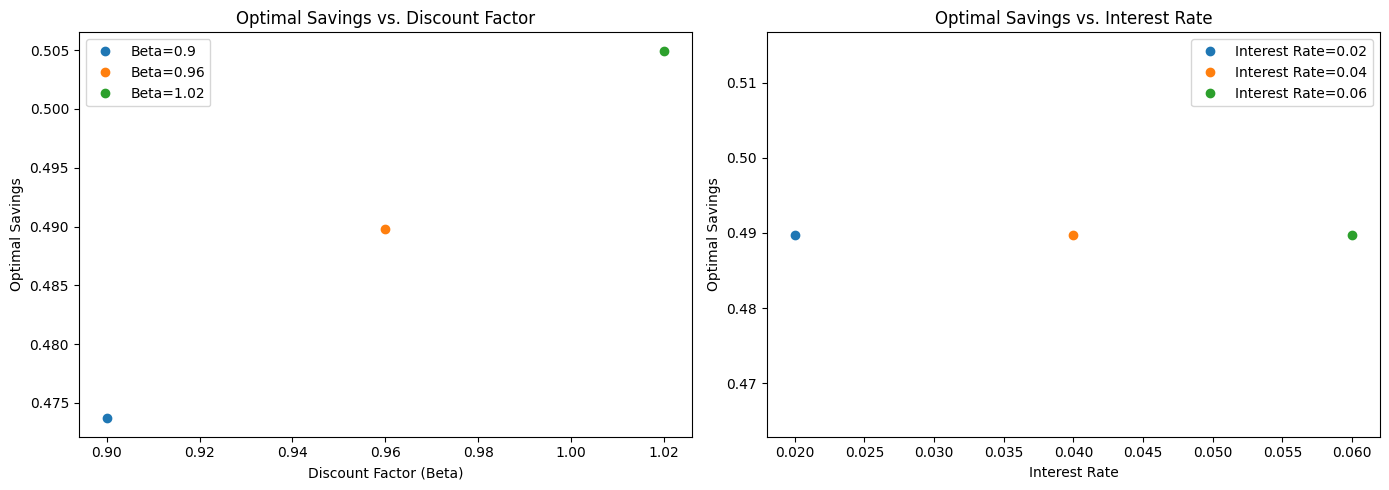

In [3]:
#Using the iterative algorithm we plot the baseline solution and different parameter values below by importing the solution from our py-file.
mp.plot_savings_solution()


Plotting the optimal savings level for different parameter values we notice a few things:
The optimal savings level is increasing in the discount factor 'beta'. This makes intuitive sense, as a higher discount factor means that the economic agent places a higher value on future consumption, making it more preferable to save more and consume less today. 

Changes in the interest rate does not affect the optimal savings level. This is due to our chosen utility function. With log utility, it holds that the income effect from a change in the interest rate equals the substituion effect. This means that the total change in the optimal savings level comes out to zero. 

We will now extend the model by relaxing the assumption of log utility. To do this we replace the log utility function with a more general CRRA (Constant relative risk aversion) utility function. This means, that agents are now maximizing the following utility function:
$$
U(c) = \frac{c^{1 - \gamma} - 1}{1 - \gamma}
$$
Here, gamma is a risk aversion parameter which we will vary later on. An important point is that $\gamma=1$ corresponds to a log utility function in the limit (the function is strictly not defined at $\gamma=1$).
We use our chosen algorithm from the previous section to solve the model again.



Gamma, Optimal Savings, Young Consumption, Old Consumption
0.5, 0.4894, 0.5106, 0.5090
1.0, 0.4898, 0.5102, 0.5094
2.0, 0.4900, 0.5100, 0.5096
3.0, 0.4901, 0.5099, 0.5097
4.0, 0.4901, 0.5099, 0.5097
5.0, 0.4901, 0.5099, 0.5097
6.0, 0.4901, 0.5099, 0.5097
7.0, 0.4901, 0.5099, 0.5097
8.0, 0.4901, 0.5099, 0.5098
9.0, 0.4902, 0.5098, 0.5098
10.0, 0.4902, 0.5098, 0.5098


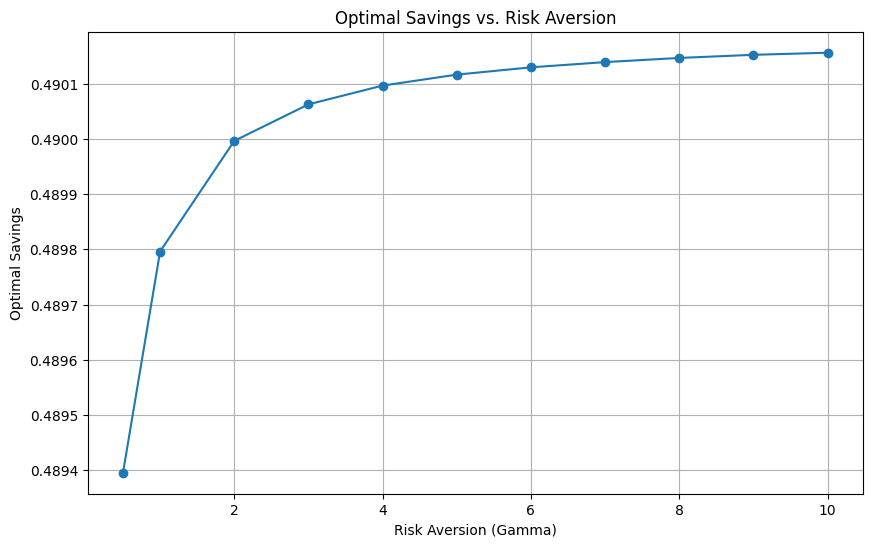

In [4]:
# Visualize the optimal savings for different utility functions, that is, solve the model for different values of gamma
mp.plot_savings_crra()

The plot above shows how the optimal savings level changes with changes in gamma. As gamma increases, agents become more risk averse. This means that they prioritize saving more strongly since they fear the uncertainty of future consumption more strongly.

Now we will investigate how the optimal savings level changes when the interest rate changes. The first case will be when $\gamma<1$. The second case will look at $\gamma>1$. We remember that $\gamma=1$ corresponds to the log utiltiy function we first looked at, where the income effect was equal to the substitution effect.

Interest Rate, Optimal Savings, Young Consumption, Old Consumption
0.01, 0.4937, 0.5063, 0.4986
0.02, 0.4924, 0.5076, 0.5023
0.03, 0.4912, 0.5088, 0.5059
0.04, 0.4900, 0.5100, 0.5096
0.05, 0.4888, 0.5112, 0.5132
0.06, 0.4876, 0.5124, 0.5169
0.07, 0.4864, 0.5136, 0.5205
0.08, 0.4853, 0.5147, 0.5241
0.09, 0.4841, 0.5159, 0.5277
0.10, 0.4830, 0.5170, 0.5313


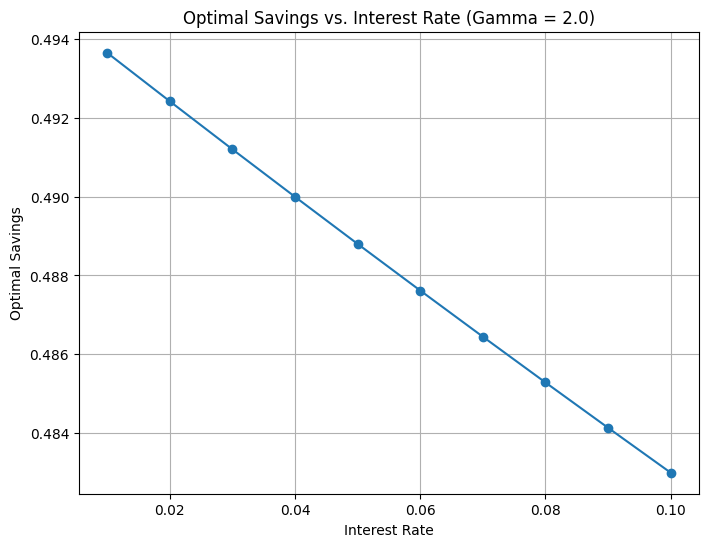

In [5]:
gamma = 2.0  # Fixed level of risk aversion (non-logarithmic)
# Visualize how interest rates affect the optimal savings with CRRA utility
mp.plot_savings_interest_rate(gamma)

The plot above shows that for gamma greater than 1 the optimal savings level is decreasing in the interest rate. This is because the substitution effect is weak for gamma greater than 1. In this case the income effect, where higher interest rates increase the overall lifetime wealth and allow for more consumption in both periods, dominates. This happens because the agent views the additional income as a reason to increase consumption today without significantly altering future consumption plans.

Interest Rate, Optimal Savings, Young Consumption, Old Consumption
0.01, 0.4821, 0.5179, 0.4869
0.02, 0.4845, 0.5155, 0.4942
0.03, 0.4870, 0.5130, 0.5016
0.04, 0.4894, 0.5106, 0.5090
0.05, 0.4918, 0.5082, 0.5164
0.06, 0.4942, 0.5058, 0.5238
0.07, 0.4965, 0.5035, 0.5313
0.08, 0.4988, 0.5012, 0.5387
0.09, 0.5011, 0.4989, 0.5462
0.10, 0.5034, 0.4966, 0.5538


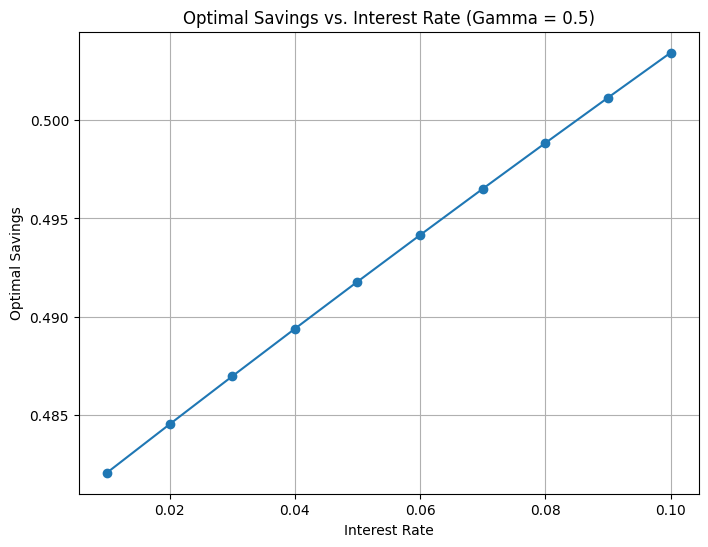

In [6]:
gamma = 0.5  # Fixed level of risk aversion (non-logarithmic)
# Visualize how interest rates affect the optimal savings with CRRA utility
mp.plot_savings_interest_rate(gamma)

The plot above shows that for values of gamma belove 1 the optimal savings level is increasing in the interest rate. This is beacuse the substitution effect is strong for gamma smaller than 1. An increase in interest rates significantly encourages more savings today to take advantage of higher future returns. Individuals are more willing to forego current consumption because they can substitute it with future consumption more easily.

The plot below is an interactive representation of how consumption shifts between period 1 where the agent is young, and period 2 where the agent is old, when different parameters change.

In [7]:
#Import our interactive plot from our py-file to display different consumption choices based on different parameter values
mp.interactive_plot

interactive(children=(FloatSlider(value=1000.0, description='Wage', max=2000.0, min=500.0, step=50.0), FloatSl…

Alot of the points we have previously made can be visualized in the plot above. Notice that the wage only changes the absolute levels of consumption and not the distrubtion between period 1 and 2. A low value of beta favours consumption while young since the agent discount more strongly. The effect of the interest rate depends on the value of gamma as previously described.

# Conclusion

This project has shown how a 2 period OLG model can be solved with an iterative, binary search algorithm to find the optimal level of savings given some parameter values. We have shown how the solution changes with parameter value changes, and we have extended the model to investigate how different utility functions impact the solution. 